This is code is meant to be used for the creation and training of a GAN for the MNIST dataset. Heavy inspiration for the DCGAN was taken from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html pytorch documentation. 

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
# Variables 
CUDA = False
batch_size = 128
img_chnl = 1
z = 100
hidden = 64
x = 64
epochs = 5
lr = 2e-4
seed = 1

In [3]:
# Establish Device
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 1.13.0


In [4]:
# Data preprocessing
dataset = dset.MNIST(root='./data', download=False,
                     transform=transforms.Compose([
                     transforms.Resize(x),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


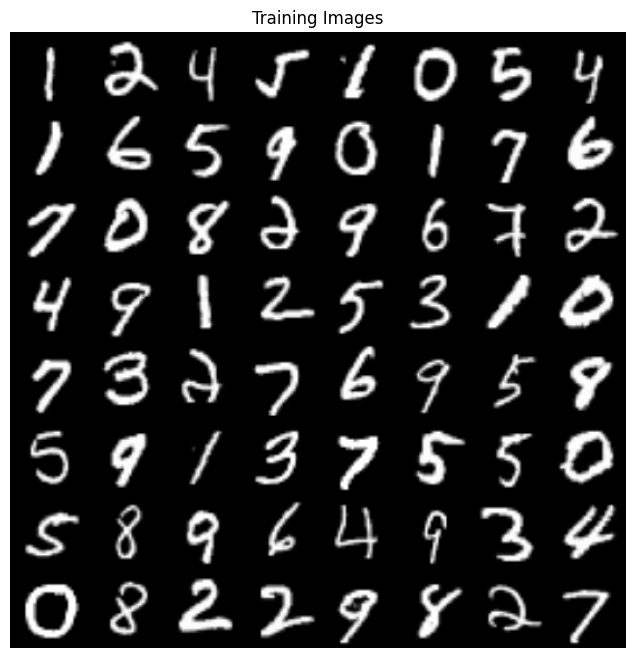

In [5]:
# Training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# Initialize weights for training 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
# Write Generator Network in Standard DCGAN for LSUN form
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z, hidden * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 8, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 4, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 2, hidden, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden, img_chnl, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [8]:
# Write Descriminator Network in Standard DCGAN for LSUN form
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_chnl, hidden, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 2, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 4, hidden * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [9]:
# Create the generator
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

# Create the discriminator
descriminator = Discriminator().to(device)
descriminator.apply(weights_init)
print(descriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
noise = torch.randn(batch_size, z, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(descriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
# Training 
# Progress Vars
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # Descriminator Step
        descriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = descriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Classify
        noise = torch.randn(b_size, z, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0)
        output = descriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator Step 
        generator.zero_grad()
        label.fill_(1)  
        output = descriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Saving Output Info
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[0/5][0/469]	Loss_D: 1.8902	Loss_G: 4.7091	D(x): 0.5633	D(G(z)): 0.6256 / 0.0144
[0/5][50/469]	Loss_D: 0.0135	Loss_G: 15.3966	D(x): 0.9871	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.0004	Loss_G: 40.9584	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][150/469]	Loss_D: 0.0012	Loss_G: 40.7501	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[0/5][200/469]	Loss_D: 0.0001	Loss_G: 40.6173	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][250/469]	Loss_D: 0.0000	Loss_G: 40.6274	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][300/469]	Loss_D: 0.0001	Loss_G: 40.4125	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][350/469]	Loss_D: 0.0000	Loss_G: 40.5559	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][400/469]	Loss_D: 0.0000	Loss_G: 40.4988	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][450/469]	Loss_D: 0.0000	Loss_G: 40.5238	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[1/5][0/469]	Loss_D: 0.0000	Loss_G: 40.4556	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][50/469]	Loss_D: 0.0000	Loss_G: 40.3813	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][100/469]	Loss_D: 0.0000	Loss_G: 40.4433	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][150/469]	Loss_D: 0.0000	Loss_G: 40.3846	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][200/469]	Loss_D: 0.0000	Loss_G: 40.1905	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][250/469]	Loss_D: 0.0000	Loss_G: 40.2698	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][300/469]	Loss_D: 0.0000	Loss_G: 40.2679	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][350/469]	Loss_D: 0.0000	Loss_G: 40.2511	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][400/469]	Loss_D: 0.0000	Loss_G: 40.2168	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][450/469]	Loss_D: 0.0000	Loss_G: 40.2214	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[2/5][0/469]	Loss_D: 0.0000	Loss_G: 40.0327	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][50/469]	Loss_D: 0.0001	Loss_G: 40.1481	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[2/5][100/469]	Loss_D: 0.0000	Loss_G: 40.0744	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][150/469]	Loss_D: 0.0000	Loss_G: 39.9971	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][200/469]	Loss_D: 0.0000	Loss_G: 39.8949	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][250/469]	Loss_D: 0.0000	Loss_G: 39.8955	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][300/469]	Loss_D: 0.0000	Loss_G: 39.8299	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][350/469]	Loss_D: 0.0000	Loss_G: 39.8998	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][400/469]	Loss_D: 0.0000	Loss_G: 39.6028	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][450/469]	Loss_D: 0.0000	Loss_G: 39.5687	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[3/5][0/469]	Loss_D: 0.0000	Loss_G: 39.6453	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][50/469]	Loss_D: 0.0000	Loss_G: 39.3472	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][100/469]	Loss_D: 0.0000	Loss_G: 39.1472	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][150/469]	Loss_D: 0.0000	Loss_G: 38.9386	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][200/469]	Loss_D: 0.0000	Loss_G: 38.1118	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][250/469]	Loss_D: 0.9281	Loss_G: 1.9275	D(x): 0.5989	D(G(z)): 0.1793 / 0.1687
[3/5][300/469]	Loss_D: 0.7896	Loss_G: 3.6228	D(x): 0.5529	D(G(z)): 0.0288 / 0.0414
[3/5][350/469]	Loss_D: 1.3621	Loss_G: 3.1369	D(x): 0.9678	D(G(z)): 0.6607 / 0.0775
[3/5][400/469]	Loss_D: 1.9128	Loss_G: 4.5845	D(x): 0.9806	D(G(z)): 0.8034 / 0.0176
[3/5][450/469]	Loss_D: 0.9022	Loss_G: 3.2041	D(x): 0.9359	D(G(z)): 0.5186 / 0.0619


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[4/5][0/469]	Loss_D: 0.8779	Loss_G: 0.9756	D(x): 0.6365	D(G(z)): 0.2871 / 0.4173
[4/5][50/469]	Loss_D: 4.6053	Loss_G: 0.5861	D(x): 0.0170	D(G(z)): 0.0072 / 0.6221
[4/5][100/469]	Loss_D: 0.8170	Loss_G: 2.5424	D(x): 0.8201	D(G(z)): 0.4303 / 0.0926
[4/5][150/469]	Loss_D: 0.7449	Loss_G: 2.0906	D(x): 0.7734	D(G(z)): 0.3574 / 0.1440
[4/5][200/469]	Loss_D: 0.7483	Loss_G: 1.1234	D(x): 0.6010	D(G(z)): 0.1619 / 0.3580
[4/5][250/469]	Loss_D: 1.5682	Loss_G: 1.3528	D(x): 0.2575	D(G(z)): 0.0333 / 0.3049
[4/5][300/469]	Loss_D: 1.7350	Loss_G: 1.8674	D(x): 0.9062	D(G(z)): 0.7290 / 0.1951
[4/5][350/469]	Loss_D: 0.7801	Loss_G: 1.6242	D(x): 0.6601	D(G(z)): 0.2555 / 0.2367
[4/5][400/469]	Loss_D: 0.6429	Loss_G: 2.8892	D(x): 0.8933	D(G(z)): 0.3814 / 0.0749
[4/5][450/469]	Loss_D: 0.6991	Loss_G: 1.3840	D(x): 0.6578	D(G(z)): 0.1957 / 0.2913


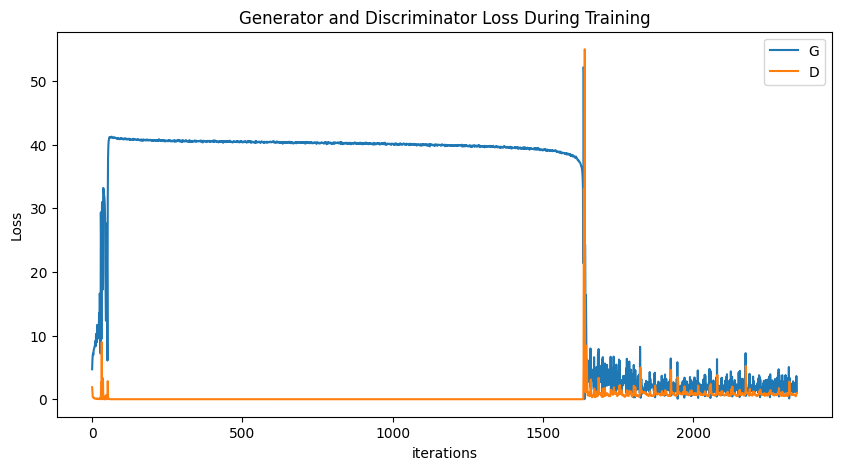

In [12]:
plt.figure(figsize=(10,5))
plt.title("generatorand Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


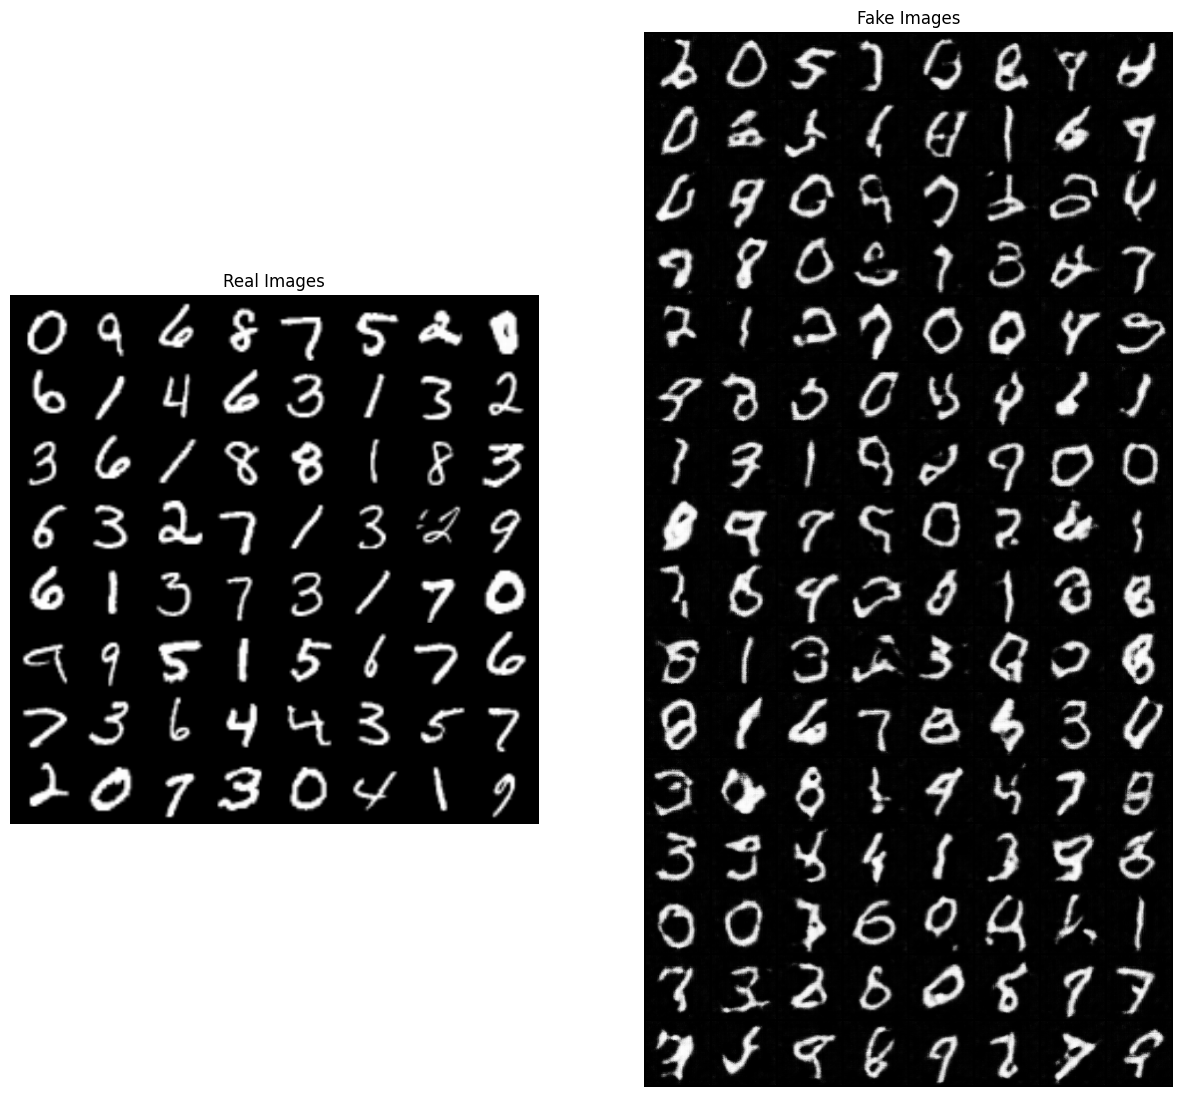

In [13]:
real_batch = next(iter(dataloader))

# Real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()